# Pyirf IRFs and sensitivity

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020
based on previous work by J. Lefacheur.

**Description:**

This notebook contains DL3 and benchmarks for the _protopipe_ + _pyirf_ pipeline. 

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 files produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.

**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update everything...

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [1]:
import os

import numpy as np
import astropy
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter
from astropy.table import Table, Column, QTable
import gammapy
from gammapy.irf import EffectiveAreaTable, EnergyDispersion2D
from matplotlib import gridspec

%matplotlib inline

In [2]:
print(astropy.__version__)
print(gammapy.__version__)

4.1
0.8


In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

# Functions

In [4]:
def get_performance(filename):
    """Load IRF, use Gammapy capabilities to handle the miragtion matrix"""
    with fits.open(filename, memmap=False) as hdulist:
        aeff = EffectiveAreaTable.from_hdulist(hdulist=hdulist).to_table()
        bkg = Table.read(hdulist["BACKGROUND"])
        psf = Table.read(hdulist["POINT SPREAD FUNCTION"])
        sens = Table.read(hdulist["SENSITIVITY"])
        #edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
        #rmf = edisp.to_energy_dispersion(offset=0.5 * u.deg)  # Projection of migration matrix, dummy angle...
        
        try:  # Collection area without score/angular cut
            aeff_no_cuts = Table.read(hdulist["SPECRESP (NO CUTS)"])
            aeff_angular_cut = Table.read(hdulist["SPECRESP (WITH ANGULAR CUT)"])
            aeff_score_cut = Table.read(hdulist["SPECRESP (WITH SCORE CUT)"])

            aeff_no_cuts.columns['SPECRESP (NO CUTS)'].name = 'SPECRESP'
            aeff_angular_cut["SPECRESP (WITH ANGULAR CUT)"].name = 'SPECRESP'
            aeff_score_cut["SPECRESP (WITH SCORE CUT)"].name = 'SPECRESP'
        except:
            pass
    
    # Collection area without score/angular cut, that will be used to contain the IRF
    # perf = dict(aeff= aeff, bkg= bkg, psf= psf, rmf=rmf, sens=sens, edisp=edisp)
    perf = dict(aeff= aeff, bkg= bkg, psf= psf, sens=sens)
    
    try:
        perf['aeff_no_cuts'] = aeff_no_cuts
        perf['aeff_angular_cut'] = aeff_angular_cut
        perf['aeff_score_cut'] = aeff_score_cut
    except:
        pass
    
    return perf

def plot_irf(axes, perf, energy_range, label=None, **kwargs):
    """Plot IRFs, take a list of axes (len=4)"""
    plot_table(axes[0], perf['bkg'], 'BGD', label, energy_range, **kwargs)
    plot_table(axes[1], perf['aeff'], 'SPECRESP', label, energy_range, **kwargs)
    plot_table(axes[2], perf['psf'], 'PSF68', label, energy_range, **kwargs)
    plot_energy_response(axes[3], perf['rmf'], label, energy_range, **kwargs)
    
    axes[0].set_xlabel('Reco energy [TeV]')
    axes[0].set_ylabel('Background rate [Hz]')
    axes[0].set_yscale('log')

    axes[1].set_xlabel('True energy [TeV]')
    axes[1].set_ylabel('Effective area [m2]')
    axes[1].set_yscale('log')
    
    axes[2].set_xlabel('Reco energy [TeV]')
    axes[2].set_ylabel('Point spread function (68%) [deg]')
    axes[2].set_ylim([0., 0.5]) # dft 0.5

    axes[3].set_xlabel('True energy [TeV]')
    axes[3].set_ylabel('Energy dispersion [%]')
    axes[3].set_ylim([-0.05, 0.85])
    
    plt.tight_layout()

def plot_sensitivity_comparison(list_perf, list_label, list_color, list_erange, perf_ref, config, title, figsize=(10, 10)):
    """Superpose a list of sensitivity and make a residual plot"""
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(5, 1, hspace=0.05)
    #ax_sens = plt.subplot(gs[:-1, :])
    ax_sens = plt.subplot(gs[:-2, :])
    #ax_res = plt.subplot(gs[4, :])
    ax_res = plt.subplot(gs[-2:, :])
    
    sens_list = [perf[config]['sens'] for perf in list_perf]
    
    for idx, sensi in enumerate(sens_list):
        plot_sensitivity(
            ax_sens,
            sensi,
            list_label[idx],
            list_erange[idx],
            **{'color': list_color[idx], 'lw': 2}
        )        
    
    emin = perf_ref[config]['sens']['ENERG_LO'][0]
    emax = perf_ref[config]['sens']['ENERG_HI'][-1]
    sens_list = []
    for perf in list_perf:
        sens_table = perf[config]['sens']
        new_t = sens_table[(sens_table['ENERG_LO'] >= 0.99 * emin) & (sens_table['ENERG_HI'] <= 1.01 * emax)]
        sens_list.append(new_t)
    
    for idx, sensi in enumerate(sens_list):
        
        plot_sensitivity_residuals(
            ax_res,
            sensi,
            perf_ref[config]['sens'],
            **{'color': list_color[idx], 'lw': 2}
        )
    
    for frac in [0.001, 0.01, 0.1, 1, 10, 100]:
        plot_crab(ax_sens, frac)
    
    sens_min =[sensi['SENSITIVITY'].min() for sensi in sens_list]
    sens_min = min(sens_min)
    
    sens_max =[sensi['SENSITIVITY'].max() for sensi in sens_list]
    sens_max = max(sens_max)
    
    ax_sens.set_xlim([0.02, 200])
    ax_sens.set_ylim([sens_min * 0.5, sens_max * 5])
    ax_sens.legend(loc='upper right', fontsize='large')
    ax_sens.set_xlabel('')
    ax_sens.set_xticklabels([])
    ax_sens.grid()
    ax_sens.loglog()
    ax_sens.set_ylabel('Sensitivity [erg / (cm2 s)]')

    ax_res.plot([-1e9, 1e9], [0., 0.], **{'color': 'darkgreen', 'lw': 2})
    ax_res.grid()
    ax_res.set_xscale('log')
    ax_res.set_ylabel('Betterness')
    ax_res.set_xlabel('Reco energy [TeV]')
    ax_res.set_xlim([0.02, 12.5])
    ax_res.set_ylim([-1, 1])

    ## Text for sensitivity
    text = "Obs. time: {}\n".format(config)
    text += "$\\alpha$=0.2 and $\\sigma$=5\n"
    text += "Syst$_{BKG}$=5% and $\\gamma_{min}$=10"
    ax_sens.text(
            0.1, 0.8 , text,
            horizontalalignment='left',
            verticalalignment='bottom',
            multialignment='left',
            bbox=dict(facecolor='white', alpha=1),
            fontsize='large',
            transform=ax_sens.transAxes
    )
    
    ax_sens.set_title(title, fontweight='bold')
    gs.tight_layout(fig)
    return ax_sens, ax_res
    
def plot_table(ax, t, colname, label, energy_range, **kwargs):
    """Simple function to plot an astropy table"""
    centers = np.sqrt(t['ENERG_LO'] * t['ENERG_HI'])
    bin_width = t['ENERG_HI'] - t['ENERG_LO']
    err_plus = t['ENERG_HI'] - centers
    err_minus = centers - t['ENERG_LO']
    values = t[colname]
    
    # Selection bins in the energy range
    idx = np.where( (centers >= energy_range[0]) & (centers <= energy_range[-1]) )
    ax.errorbar(centers[idx], values[idx], xerr=(err_minus[idx],err_plus[idx]), label=label, **kwargs)
    
    return ax

def plot_energy_response(ax, rmf, label, energy_range, **kwargs):
    """Simple function to plot the energy resolution (Gammapy)"""
    energy = rmf.e_true.nodes
    bias = rmf.get_bias(energy)
    resol = rmf.get_resolution(energy)
    
    idx = np.where( (energy.value >= energy_range[0]) & (energy.value <= energy_range[-1]) )
    
    ax.errorbar(energy.value[idx], bias[idx], **kwargs, ls='--')
    ax.errorbar(energy.value[idx], resol[idx], label=label, **kwargs, ls='-')
    return ax

def plot_sensitivity(ax, t, label, energy_range, **kwargs):
    plot_table(ax, t, 'SENSITIVITY', label, energy_range, **kwargs)
    return ax

def plot_sensitivity_residuals(ax, table_sens, table_ref,**kwargs):
    emin = table_ref['ENERG_LO'][0]
    emax = table_ref['ENERG_HI'][-1]
    t = table_sens[(table_sens['ENERG_LO'] >= 0.99 * emin) & (table_sens['ENERG_HI'] <= 1.01 * emax)]
    
    t_ratio = Table()
    t_ratio['ENERG_LO'] = t['ENERG_LO'].data
    t_ratio['ENERG_HI'] = t['ENERG_HI'].data
    t_ratio['RATIO'] = (1. - (t['SENSITIVITY'] / table_ref['SENSITIVITY']))
    
    plot_table(ax=ax, t=t_ratio, colname='RATIO', label=None, energy_range=[0.01, 300.], **kwargs)
    return ax

def plot_crab(ax, fraction):
    """Plot Crab spectra"""
    crab_model = CrabSpectrum('hegra').model
    reference = 1 * u.TeV
    amplitude = crab_model(energy=reference) * fraction
    index = CrabSpectrum('hegra').model.parameters['index'].value
    energy = np.logspace(-3, 3, 100) * u.TeV
    flux = PowerLaw(amplitude=amplitude, reference=reference, index=index)(energy)
    e2flux = (flux * energy **2) * u.TeV.to('erg')
    ax.plot(energy.value, e2flux.value, ls='--', lw=2, color='grey', alpha=0.5)

## Load ...

First we check if a _plots_ folder exists already.  
If not, we create it.

In [5]:
#Path("./plots_DL3").mkdir(parents=True, exist_ok=True)

### ... protopipe's performance

In [6]:
# File
file_pyirf = '/cta/verna/Desktop/PhD/Work/CTA/protopipe/benchmarks/DL3/reference_data/test/pyirf_protopipe.fits.gz'
file_protopipe = '/cta/verna/Desktop/PhD/Work/CTA/protopipe/benchmarks/DL3/reference_data/test/irf_tail_ThSq_r68_Time50.00h/'

perf_protopipe = get_performance(file_protopipe + 'irf.fits.gz')

### ... ASWG's performance

In [7]:
indir = './reference_data/aswg/point-like/LaPalma_20_South'
indir = os.path.expandvars(indir)
    
filenames = {
    '50h': 'CTA-Performance-North-20deg-S-onaxis-50h_20170627.fits.gz'
}
perf_mars_fullarray = dict()
for key in filenames.keys():
    perf_mars_fullarray[key] = get_performance(os.path.join(indir, filenames[key]))

# Load Requirements

In [8]:
indir = './reference_data/requirements/'

# Full array
infiles = dict(sens='/North-50h.dat') # 50 h
requirements = dict()
for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')
requirements['sens'].add_column(Column(data=(10**requirements['sens']['col1']), name='ENERGY'))
requirements['sens'].add_column(Column(data=requirements['sens']['col2'], name='SENSITIVITY'))

In [9]:
indir = './reference_data/requirements/'

# Full array
infiles = dict(
    SENSITIVITY='/North-50h.dat',
    ANGULAR_RESOLUTION='/North-50h-AngRes.dat',
    ENERGY_RESOLUTION='/North-50h-ERes.dat', # How is it defined?
    #EFFECTIVE_AREA='North-50h-EffectiveArea.dat',
    )
requirements = dict()

for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')

for key in infiles.keys():
    requirements[key].add_column(Column(data=(10**requirements[key]['col1']), name='ENERGY'))
    requirements[key].add_column(Column(data=requirements[key]['col2'], name=key))


## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut (R68)
[back to top](#Table-of-contents)

In [10]:
# protopipe cuts
cuts_table_protopipe = Table.read(file_protopipe + 'table_best_cutoff.fits', format='fits')

# pyirf theta cuts
rad_max = QTable.read(file_pyirf, hdu='RAD_MAX')[0]
# pyirf gh cuts
gh_cut = QTable.read(file_pyirf, hdu='GH_CUTS')[1:-1]

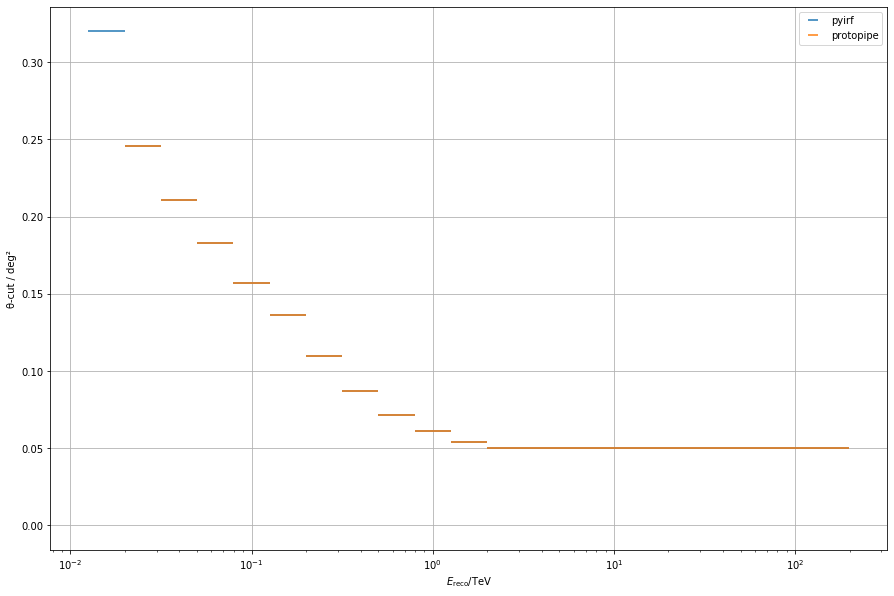

In [12]:
# pyirf
plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='pyirf',
)
# protopipe
plt.errorbar(
    0.5 * (cuts_table_protopipe['emin'] + cuts_table_protopipe['emax']),
    cuts_table_protopipe['angular_cut'],
    xerr=0.5 * (cuts_table_protopipe['emax'] - cuts_table_protopipe['emin']),
    ls='',
    label='protopipe',
)

plt.legend()
plt.ylabel('θ-cut / deg²')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid()

None # to remove clutter by mpl objects

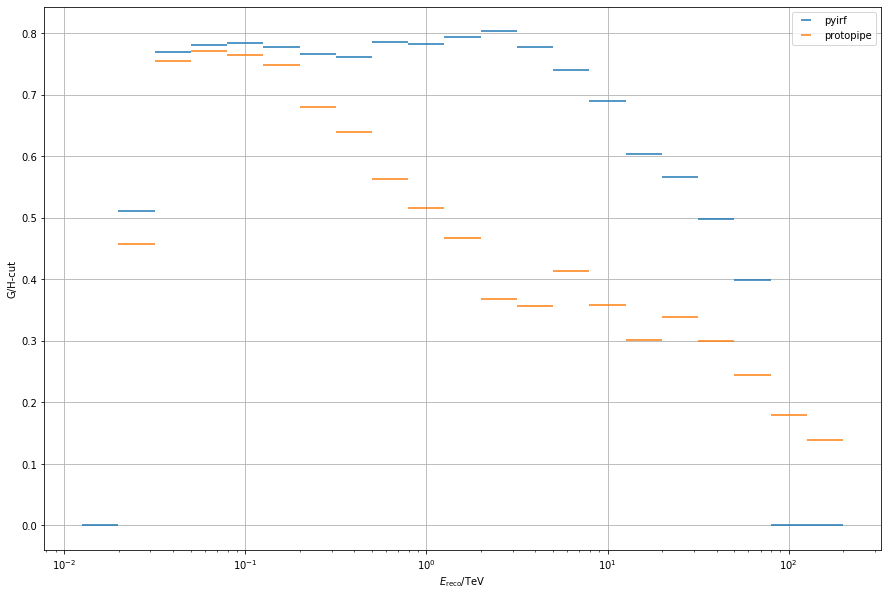

In [13]:
# pyirf
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='pyirf',
)
# protopipe
plt.errorbar(
    0.5 * (cuts_table_protopipe['emin'] + cuts_table_protopipe['emax']),
    cuts_table_protopipe['best_cutoff'],
    xerr=0.5 * (cuts_table_protopipe['emax'] - cuts_table_protopipe['emin']),
    ls='',
    label='protopipe',
)

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid()

None # to remove clutter by mpl objects

/cta/verna/anaconda3/envs/protopipe/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


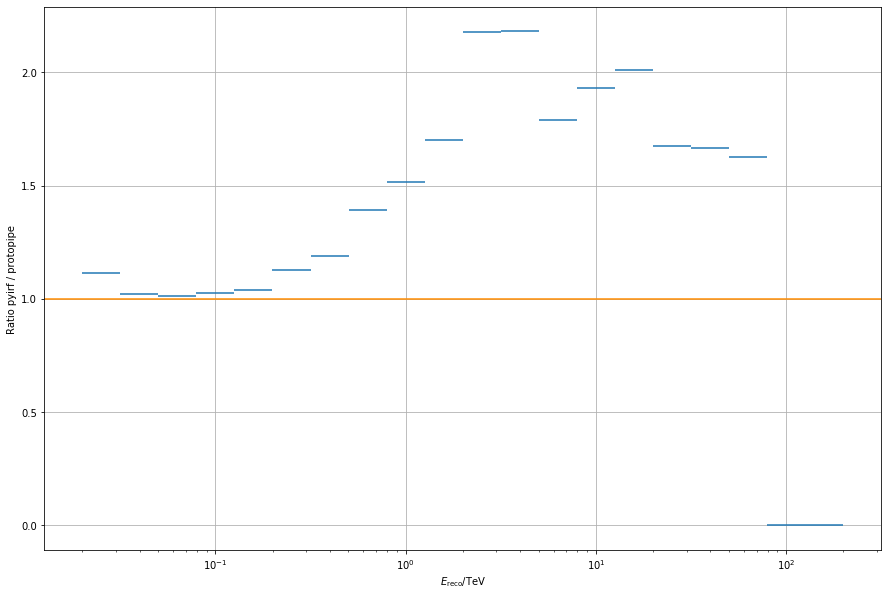

In [14]:
# ratio pyirf / protopipe
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    np.divide(gh_cut['cut'],cuts_table_protopipe['best_cutoff']),
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
)
plt.axhline(1,color='DarkOrange')

plt.ylabel('Ratio pyirf / protopipe')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid()

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [15]:
# pyirf sensitivity
# [1:-1] removes under/overflow bins
sensitivity = QTable.read(file_pyirf, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity['reco_energy_low'].info.format = '.3g'
sensitivity['reco_energy_high'].info.format = '.3g'
sensitivity['reco_energy_center'].info.format = '.3g'
sensitivity['n_signal'].info.format = '.1f'
sensitivity['n_signal_weighted'].info.format = '.1f'
sensitivity['n_background_weighted'].info.format = '.1f'
sensitivity['n_background'].info.format = '.1f'
sensitivity['relative_sensitivity'].info.format = '.2g'
sensitivity['flux_sensitivity'].info.format = '.3g'

sensitivity

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_background,n_signal_weighted,n_background_weighted,failed_checks,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
0.0126,0.02,0.0163,107.4,4.1,182.5,5201.3,4,nan,nan
0.02,0.0316,0.0258,460.3,61.1,611.4,61116.0,0,0.14,5.75e-08
0.0316,0.0501,0.0409,611.6,164.1,596.0,58056.5,0,0.041,5.08e-09
0.0501,0.0794,0.0648,783.2,270.2,592.4,57340.8,0,0.024,8.79e-10
0.0794,0.126,0.103,1053.7,417.4,593.7,57604.5,0,0.017,1.82e-10
0.126,0.2,0.163,1454.1,694.8,609.8,60803.7,0,0.014,4.52e-11
0.2,0.316,0.258,1285.4,546.7,397.0,25498.6,0,0.012,1.15e-11
0.316,0.501,0.409,950.8,313.3,219.0,7571.4,0,0.01,2.99e-12


In [16]:
cuts_table_protopipe['emin'].info.format = '.3g'
cuts_table_protopipe['emax'].info.format = '.3g'
cuts_table_protopipe['non'].info.format = '.1f'
cuts_table_protopipe['noff'].info.format = '.1f'
cuts_table_protopipe['background'].info.format = '.1f'
cuts_table_protopipe['excess'].info.format = '.1f'
cuts_table_protopipe['min_flux'].info.format = '.3g'

cuts_table_protopipe[['emin','emax','non','noff','background','excess','min_flux']]

emin,emax,non,noff,background,excess,min_flux
TeV,TeV,,,,,
float64,float64,float64,float64,float64,float64,float64
0,0,0.0,0.0,0.0,0.0,0
0.02,0.0316,13481.8,64199.2,12839.8,626.5,0.117
0.0316,0.0501,11922.4,56728.4,11345.7,576.8,0.02
0.0501,0.0794,11400.1,54181.1,10836.2,563.9,0.012
0.0794,0.126,12683.5,60325.5,12065.1,618.4,0.008
0.126,0.2,8791.1,41613.4,8322.7,468.5,0.006
0.2,0.316,4777.4,22067.7,4413.5,363.9,0.006
0.316,0.501,1403.5,6683.2,1336.6,10.0,0.00182


## Plot sensitivity

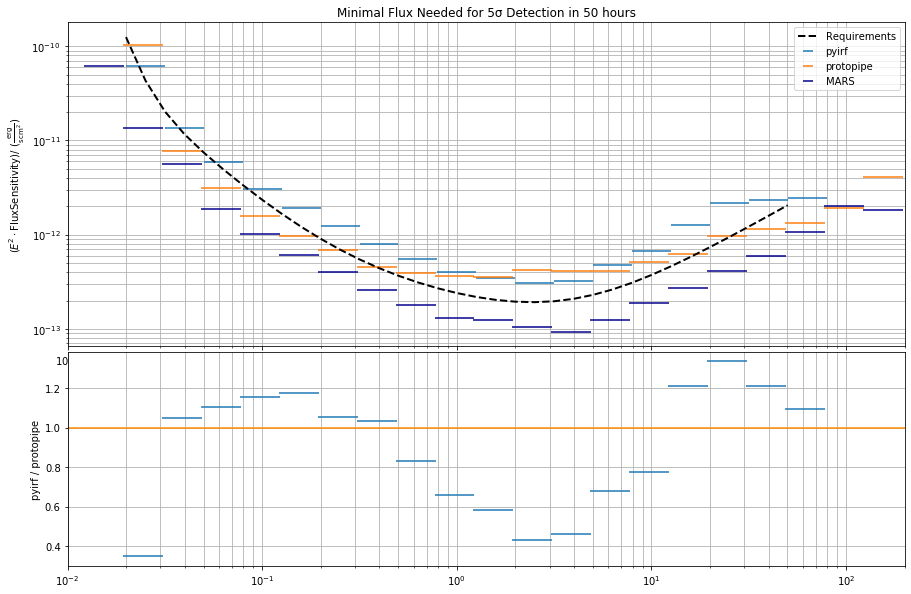

In [17]:
#a= plt.figure(figsize=(12,8))
#ax= a.add_axes([0.1,0.1,0.8,0.8])

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(5, 1, hspace=0.05)
ax_sens = plt.subplot(gs[:-2, :])
ax_ratio = plt.subplot(gs[-2:, :])

# pyirf sensitivity
unit = u.Unit('erg cm-2 s-1')
e = sensitivity['reco_energy_center'][1:]
s = (e**2 * sensitivity['flux_sensitivity'][1:])
w = (sensitivity['reco_energy_high'] - sensitivity['reco_energy_low'])[1:]
ax_sens.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='pyirf'
)

# protopipe sensitivity
e = np.sqrt(perf_protopipe['sens']['ENERG_LO'] * perf_protopipe['sens']['ENERG_HI'])
s = perf_protopipe['sens']['SENSITIVITY']
w = (perf_protopipe['sens']['ENERG_HI'] - perf_protopipe['sens']['ENERG_LO'])
ax_sens.errorbar(
    e,
    s,
    xerr=w / 2,
    ls='',
    label='protopipe'
)

# Requirements
ax_sens.plot(requirements['SENSITIVITY']['ENERGY'],
         requirements['SENSITIVITY']['SENSITIVITY'],
         color='black',
         ls='--',
         lw=2,
         label='Requirements')

# MARS
e_low = perf_mars_fullarray['50h']['sens']['ENERG_LO']
e_high = perf_mars_fullarray['50h']['sens']['ENERG_HI']
e = np.sqrt(e_low * e_high)
s = perf_mars_fullarray['50h']['sens']['SENSITIVITY']
w = (e_high - e_low)
ax_sens.errorbar(
    e,
    s,
    xerr=w / 2,
    ls='',
    color='DarkBlue',
    label='MARS'
)

# Style settings
ax_sens.set_title('Minimal Flux Needed for 5σ Detection in 50 hours')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_xlim(0.01,200)
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

ax_sens.grid(which="both")
ax_sens.legend()


ratio = np.divide((e[1:]**2 * sensitivity['flux_sensitivity'][1:].value),perf_protopipe['sens']['SENSITIVITY'])
ax_ratio.errorbar(
    e[1:],
    ratio,
    xerr=w[1:] / 2,
    ls=''
)
ax_ratio.axhline(1,color='DarkOrange')
ax_ratio.set_xscale("log")
ax_ratio.set_xlim(0.01,200)
ax_ratio.grid(which="both")
ax_ratio.set_ylabel("pyirf / protopipe")

None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

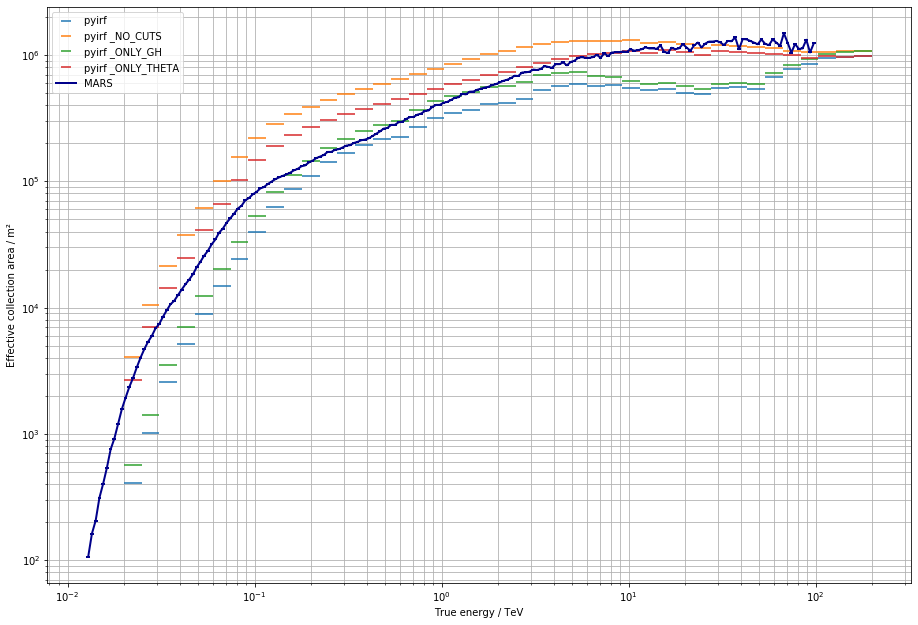

In [18]:
# Data pyirf
a= plt.figure()
ax= a.add_axes([0.1,0.1,0.8,0.8])

for name in ('', '_NO_CUTS', '_ONLY_GH', '_ONLY_THETA'):

    area = QTable.read(file_pyirf, hdu='EFFECTIVE_AREA' + name)[0]
    
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='pyirf ' + name,
    )

"""
# Requirements
plt.plot(requirements['EFFECTIVE_AREA']['ENERGY'],
         requirements['EFFECTIVE_AREA']['EFFECTIVE_AREA'],
         color='black',
         ls='--',
         lw=2,
         label='Requirements')
"""
         
# Reference data: MARS
plot_table(
    ax,
    t = perf_mars_fullarray['50h']['aeff'], 
    colname = 'SPECRESP', 
    label='MARS', 
    energy_range =[0.01, 100.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

NameError: name 'perf' is not defined

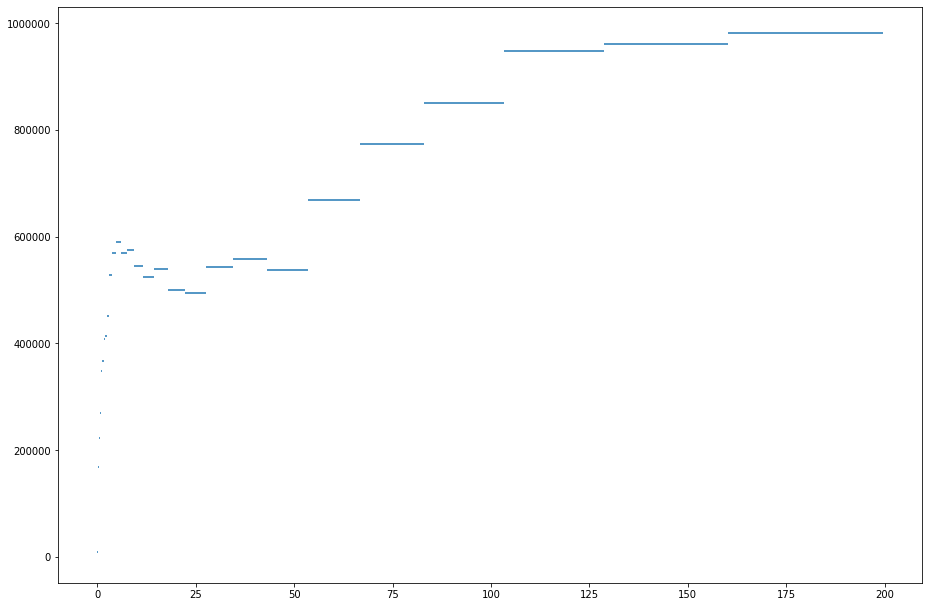

In [19]:
# Data pyirf
a= plt.figure()
ax= a.add_axes([0.1,0.1,0.8,0.8])

area = QTable.read(file_pyirf, hdu='EFFECTIVE_AREA')[0]

# pyirf Effective Area
plt.errorbar(
    0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
    area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
    xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
    ls='',
    label='pyirf',
)

# protopipe Effective Area
aeff = 'aeff'
e = np.sqrt(perf[aeff]['ENERG_LO'] * perf[aeff]['ENERG_HI'])
a = perf[aeff]['SPECRESP']
w = (perf[aeff]['ENERG_HI'] - perf[aeff]['ENERG_LO'])
plt.errorbar(
    e,
    a,
    xerr=w/2,
    ls='',
    label='protopipe',
)


"""
# Requirements
plt.plot(requirements['EFFECTIVE_AREA']['ENERGY'],
         requirements['EFFECTIVE_AREA']['EFFECTIVE_AREA'],
         color='black',
         ls='--',
         lw=2,
         label='Requirements')
"""
         
# Reference data: MARS
plot_table(
    ax,
    t = perf_mars_fullarray['50h']['aeff'], 
    colname = 'SPECRESP', 
    label='MARS', 
    energy_range =[0.01, 100.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

In [ ]:
# Data pyirf
a= plt.figure()
ax= a.add_axes([0.1,0.1,0.8,0.8])

area = QTable.read(file_pyirf, hdu='EFFECTIVE_AREA_NO_CUTS')[0]

# pyirf Effective Area
plt.errorbar(
    0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
    area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
    xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
    ls='',
    label='pyirf',
)

# protopipe Effective Area
aeff = 'aeff_no_cuts'
e = np.sqrt(perf[aeff]['ENERG_LO'] * perf[aeff]['ENERG_HI'])
a = perf[aeff]['SPECRESP']
w = (perf[aeff]['ENERG_HI'] - perf[aeff]['ENERG_LO'])
plt.errorbar(
    e,
    a,
    xerr=w/2,
    ls='',
    label='protopipe',
)

"""
# Requirements
plt.plot(requirements['EFFECTIVE_AREA']['ENERGY'],
         requirements['EFFECTIVE_AREA']['EFFECTIVE_AREA'],
         color='black',
         ls='--',
         lw=2,
         label='Requirements')
"""
         
# Reference data: MARS
plot_table(
    ax,
    t = perf_mars_fullarray['50h']['aeff'], 
    colname = 'SPECRESP', 
    label='MARS', 
    energy_range =[0.01, 100.], 
    **{'color': 'darkblue', 'lw': 2})

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

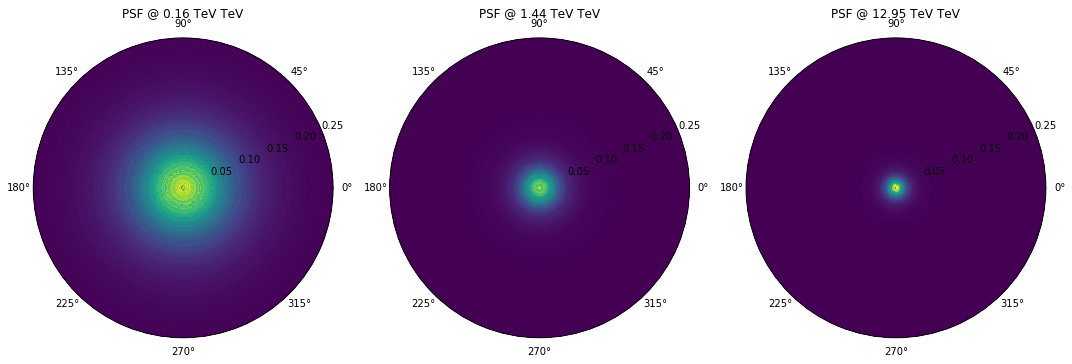

In [20]:
psf_table = QTable.read(file_pyirf, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects

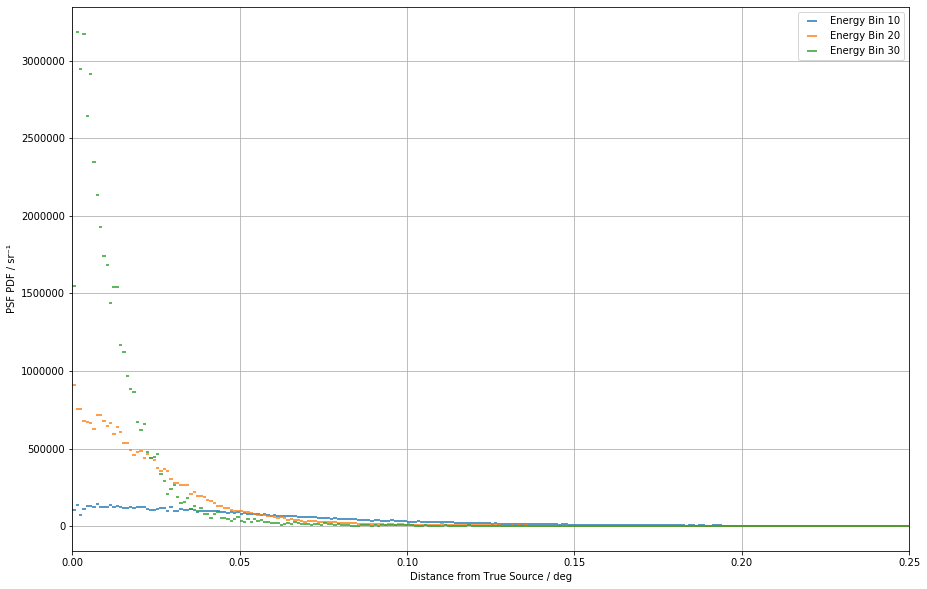

In [21]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')
plt.grid()

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

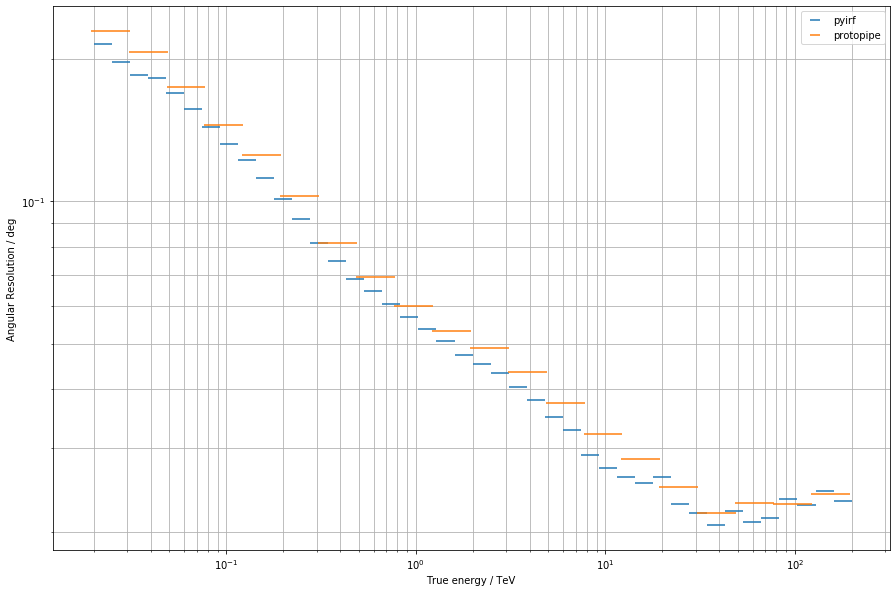

In [22]:
# pyirf
ang_res = QTable.read(file_pyirf, hdu='ANGULAR_RESOLUTION')[1:-1]

# psf pyirf (vs energy TRUE)!!!!
plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)

# psf protopipe (vs energy RECO)!!!!
e = np.sqrt(perf_protopipe['psf']['ENERG_LO'] * perf_protopipe['psf']['ENERG_HI'])
p = perf_protopipe['psf']['PSF68']
w = (perf_protopipe['psf']['ENERG_HI'] - perf_protopipe['psf']['ENERG_LO'])
plt.errorbar(
    e,
    p,
    xerr=w/2,
    ls='',
    label='protopipe'
)


# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

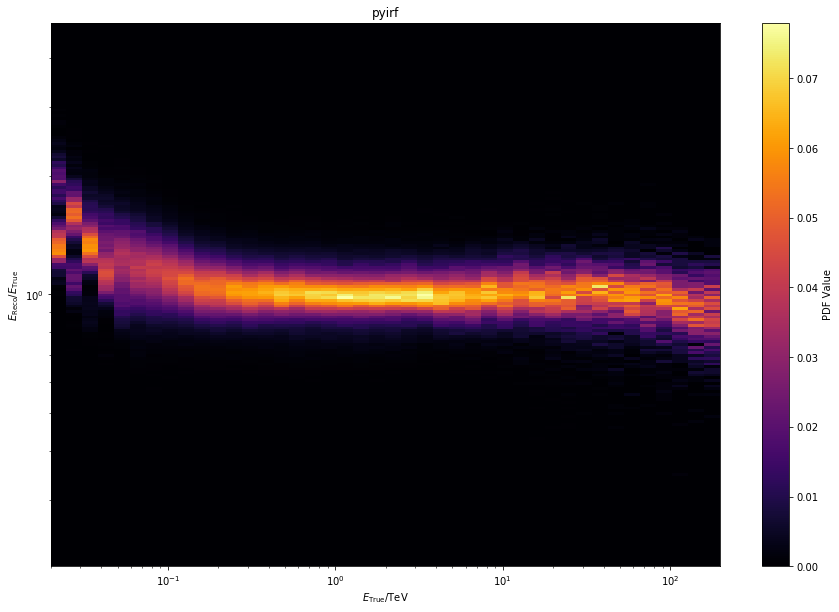

In [23]:
edisp = QTable.read(file_pyirf, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('pyirf')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

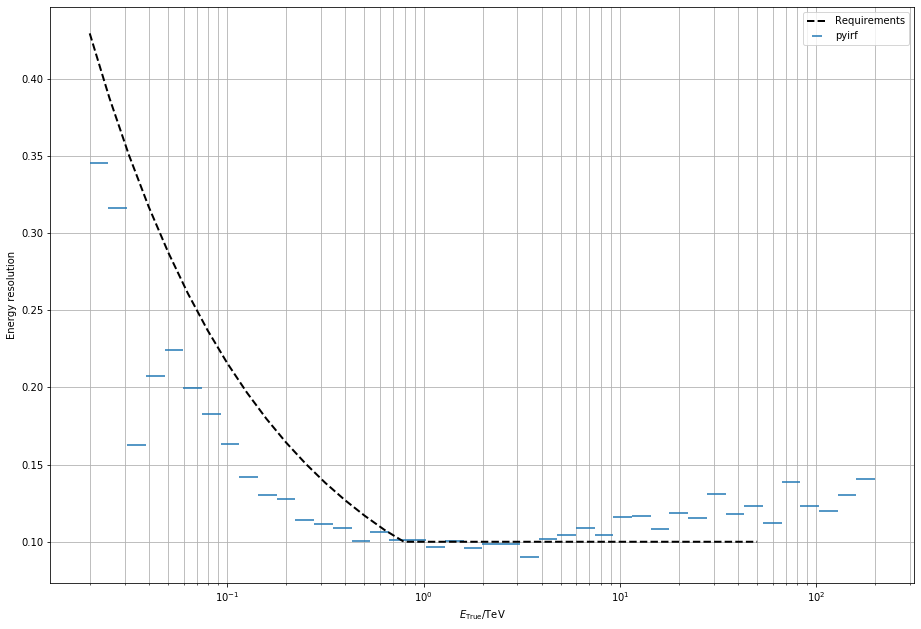

In [24]:
# pyirf
a= plt.figure()
ax= a.add_axes([0.1,0.1,0.8,0.8])

bias_resolution = QTable.read(file_pyirf, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
    ls='',
    label='pyirf'
)
plt.xscale('log')

# Requirements
plt.plot(requirements['ENERGY_RESOLUTION']['ENERGY'],
             requirements['ENERGY_RESOLUTION']['ENERGY_RESOLUTION'],
             color='black',
             ls='--',
             lw=2,
             label='Requirements')

# Reference data: MARS
"""plot_energy_response(
    ax,
    perf_mars_fullarray['50h']['rmf'], 
    label='MARS', 
    energy_range =[0.01, 51.], 
    **{'color': 'darkblue', 'lw': 2})"""

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

/cta/verna/anaconda3/envs/protopipe/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


NameError: name 'perf' is not defined

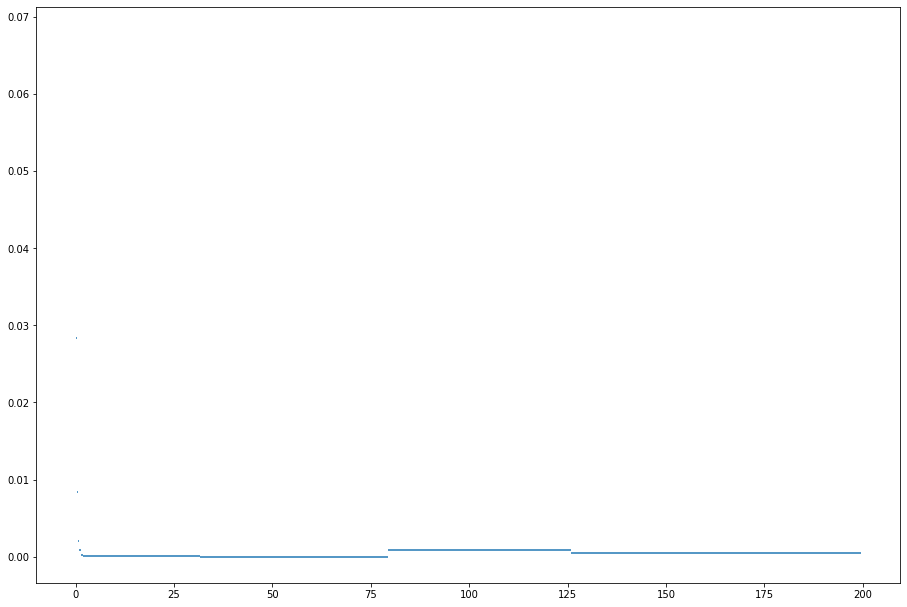

In [25]:
from pyirf.utils import cone_solid_angle

a= plt.figure()
ax= a.add_axes([0.1,0.1,0.8,0.8])

# pyirf data
bg_rate = QTable.read(file_pyirf, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)


# pyirf bkg rate
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='pyirf',
)

# protopipe bkg rate
e = np.sqrt(perf_protopipe['bkg']['ENERG_LO'] * perf_protopipe['bkg']['ENERG_HI'])
p = perf['bkg']['BGD']
w = (perf['bkg']['ENERG_HI'] - perf['bkg']['ENERG_LO'])
plt.errorbar(
    e,
    p,
    xerr=w/2,
    ls='',
    label='protopipe'
)

# Reference data: MARS
plot_table(
    ax,
    perf_mars_fullarray['50h']['bkg'], 
    'BGD', 
    label='MARS', 
    energy_range =[0.01, 100], 
    **{'color': 'darkblue'})

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects